# Compare Spatiotemporal Power Spectra for different Conditions

How do different conditions compare!?!?

## Dependencies

In [1]:
import os, stat
import numpy as np
import matplotlib.pyplot as plt
import imp

import utils.run_analysis as ana

import stftoolkit as stf
import datatable as dt

import imageio
import cv2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import matplotlib.colors as colors

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/data_repo/bravo'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 200

chunk_secs = 2
chunk_pix = 128
chunk_frames = int(chunk_secs*fps)

num_chunks = 500

trace_type='none'

cosine_window = True

#where are there atifacts? cut them off before plotting
spatial_cuttoff_cpd = 12
temporal_cuttoff_fps = np.inf

#vertical_ppd = img_dims[0]/vertical_fov_deg
horizontal_ppd = img_dims[1]/horizontal_fov_deg
#ppd = np.mean((vertical_ppd, horizontal_ppd))
ppd = horizontal_ppd
#print(f'Vertical PPD: {vertical_ppd:.2f}, Horizontal PPD {horizontal_ppd:.2f}, taking average {ppd:.2f}')

## Specify Directories for Exmaple

In [3]:
task = 'chat_1'

comparison_save_dir = './output/comparison'
try:
    os.mkdir(comparison_save_dir)
except:
    print('already made!')

static_condition = ['buddy','none']
headbody_condition = ['ag','none']
eye_condition = ['ag','fixation_eye_0']

already made!


## Get Power Spectra for 3 Conditions

In [4]:
#Static Camera
static_save_dir = os.path.join('./output', static_condition[0], task)
static_ps_3d = np.load(os.path.join(static_save_dir,f'ps_3d_mean_{num_chunks}_{static_condition[1]}.npy'))
static_ps_2d = np.load(os.path.join(static_save_dir,f'ps_2d_mean_{num_chunks}_{static_condition[1]}.npy'))
static_fqs_space = np.load(os.path.join(static_save_dir,f'ps_fqs_space_{num_chunks}_{static_condition[1]}.npy'))
static_fqs_time = np.load(os.path.join(static_save_dir,f'ps_fqs_time_{num_chunks}_{static_condition[1]}.npy'))

#Body & Head
headbody_save_dir = os.path.join('./output', headbody_condition[0], task)
headbody_ps_3d = np.load(os.path.join(headbody_save_dir,f'ps_3d_mean_{num_chunks}_{headbody_condition[1]}.npy'))
headbody_ps_2d = np.load(os.path.join(headbody_save_dir,f'ps_2d_mean_{num_chunks}_{headbody_condition[1]}.npy'))
headbody_fqs_space = np.load(os.path.join(headbody_save_dir,f'ps_fqs_space_{num_chunks}_{headbody_condition[1]}.npy'))
headbody_fqs_time = np.load(os.path.join(headbody_save_dir,f'ps_fqs_time_{num_chunks}_{headbody_condition[1]}.npy'))

#Eye Motion
eye_save_dir = os.path.join('./output', eye_condition[0], task)
eye_ps_3d = np.load(os.path.join(eye_save_dir,f'ps_3d_mean_{num_chunks}_{eye_condition[1]}.npy'))
eye_ps_2d = np.load(os.path.join(eye_save_dir,f'ps_2d_mean_{num_chunks}_{eye_condition[1]}.npy'))
eye_fqs_space = np.load(os.path.join(eye_save_dir,f'ps_fqs_space_{num_chunks}_{eye_condition[1]}.npy'))
eye_fqs_time = np.load(os.path.join(eye_save_dir,f'ps_fqs_time_{num_chunks}_{eye_condition[1]}.npy'))

assert(np.array_equal(static_fqs_space, headbody_fqs_space))
assert(np.array_equal(static_fqs_space, eye_fqs_space))
assert(np.array_equal(static_fqs_time, headbody_fqs_time))
assert(np.array_equal(static_fqs_time, eye_fqs_time))

fqs_space = static_fqs_space
fqs_time = static_fqs_time



## Cuttoff Aliasing

In [5]:
fqs_space_keep = fqs_space <= spatial_cuttoff_cpd
fqs_time_keep = fqs_time <= temporal_cuttoff_fps

static_ps_3d = static_ps_3d[np.ix_(fqs_time_keep, fqs_space_keep, fqs_space_keep)]
static_ps_2d = static_ps_2d[np.ix_(fqs_space_keep, fqs_time_keep)]

headbody_ps_3d = headbody_ps_3d[np.ix_(fqs_time_keep, fqs_space_keep, fqs_space_keep)]
headbody_ps_2d = headbody_ps_2d[np.ix_(fqs_space_keep, fqs_time_keep)]

eye_ps_3d = eye_ps_3d[np.ix_(fqs_time_keep, fqs_space_keep, fqs_space_keep)]
eye_ps_2d = eye_ps_2d[np.ix_(fqs_space_keep, fqs_time_keep)]

fqs_space = fqs_space[np.ix_(fqs_space_keep)]                        
fqs_time = fqs_time[fqs_time_keep]    

## Plot All on Same Color Axis

In [6]:
#spacecolors = plt.cm.get_cmap('hsv')


def da_plot_power(power_spectrum, fqspace, fqtime, nsamples = 5, minmaxcolors=(None, None), figname='Plot', saveloc='./output', logscale=True, show_onef_line=True, grey_contour=True, vector_save=False, legend_loc=0, cmap='hsv'):
    '''
    THE Dong & Attick Plot (Dong & Attick 1995; fig 7) with heatmap added.
    Produces three plots:
        - Heatmap displying the joint spatial/temporal amplitude
        - Samples from this plot along spatial and temporal lines:
            * plots of spatial power spectrum along given temporal values
            * plots of temporal spectrum along given spatial values

    Parameters
    ----------
        power_spectrum:   2d numpy array of spatio/temporal power
        fqspace:    1d numpy array of spatial frequency vals for spectrum
        fqtime:   1d numpy array of temporal frequency vals for spectrum
        nsamples: integer number of lines to plot for sampling plots
        power (bool):   Are we calculating the power spectrum (default) or amplitude
        psd (bool):     Normalize to power spectral density (default), or raw power?
        figname (str):  String prefix to name of figure to be saved
    
    Returns:
    --------
        mftchunk
        azmchunk
        freqspace1d
        freqspacefull
        freqtime

    '''
    #dims got a little messed up. This is the quickest fix. Later go in and change idxs in code.
    #power_spectrum = power_spectrum.T
    
    #calculate sampling positions
    #space
    space_end_offset = 1
    space_end_sample = len(fqspace)-space_end_offset #sample everything for now
    #time
    time_end_offset = 1
    time_end_sample = len(fqtime)-time_end_offset #sample everything for now
    #joint
    n_datpoints = len(fqspace)*len(fqtime)
    
    #colors for lines: generate by indexes in log coordinates.
    spacesamplefqs_idx = np.round(np.geomspace(space_end_offset, space_end_sample,
                                      nsamples),0).astype(int)
    timesamplefqs_idx = np.round(np.geomspace(time_end_offset, time_end_sample,
                                     nsamples),0).astype(int)

    spacecolors = lambda x: plt.cm.get_cmap(cmap)(x / nsamples * 0.5 + 0.25)
#     spacecolors = np.array(['saddlebrown','brown', 'chocolate', 'darkgoldenrod','orange', 'gold','yellow'])#[::-1]
    timecolors = spacecolors

    #make a grid
    fig = plt.figure(figsize=(9,5))
    full_grid = gsp.GridSpec(2,3)
    
    #layout of subplots
    grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
    grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
    grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])
    
    #heatmap
    axes_hm = plt.subplot(grid_hm[0])
    
    #take log
    #power_spectrum = np.log10(power_spectrum)
    
    if(minmaxcolors[0]):
        minc = np.log10(np.abs(minmaxcolors[0]))
        maxc = np.log10(np.abs(minmaxcolors[1]))
    else:
        minc = np.min(np.log10(power_spectrum))
        maxc = np.max(np.log10(power_spectrum))

    clev = np.arange(minc,maxc,0.5)
    if(grey_contour):
        hm = axes_hm.contourf(fqtime, fqspace, np.log10(power_spectrum),
                              clev,
                              cmap='gray',
                              norm=mpl.colors.Normalize(minc, maxc))
    else:
        hm = axes_hm.contourf(fqtime, fqspace, np.log10(power_spectrum),
                              clev,
                              cmap='viridis',
                              norm=mpl.colors.Normalize(minc, maxc))    
    if(logscale):
        axes_hm.set_xscale("log") 
        axes_hm.set_yscale("log")
    axes_hm.set_xlabel('Hz')
    axes_hm.set_ylabel('cycles/deg')
    axes_hm.set_title(f'{figname} Log Power') 
    
    cb = plt.colorbar(hm)
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

    #add lines
    for s in range(nsamples):
        #lines in time
        axes_hm.axvline(fqtime[timesamplefqs_idx[s]],c=timecolors(s),ls='-')
        #lines in space
        axes_hm.axhline(fqspace[spacesamplefqs_idx[s]],c=spacecolors(s),ls='--')

    #spaceplot
    axes_space = plt.subplot(grid_space[0])
    for i, tf_idx in enumerate(timesamplefqs_idx):
        axes_space.loglog(fqspace, power_spectrum[:,tf_idx],
                        label='{0:.0f} Hz  '.format(fqtime[tf_idx]),
                        c=timecolors(i))
    
    #print(np.log(np.max(power_spectrum)/fqspace))
    if(show_onef_line):
        fqs = fqspace[space_end_offset:space_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum[:,timesamplefqs_idx[0]])
        axes_space.loglog(fqs, onef, c='black')
        axes_space.plot(fqs, onef2, c='black')
    
    axes_space.set_title('Spatial Frequency')
    axes_space.set_xlabel('cpd')
    axes_space.set_ylabel(f'Power')
    #axes_space.set_xlim(fqspace[1],fqspace[-1])
    #axes_space.set_ylim(bottom=minc, top=maxc)
    axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_space.legend(fontsize=8,loc=legend_loc, bbox_to_anchor=(1.5, 1.0))

    #timeplot
    axes_time = plt.subplot(grid_time[0])
    for i, sf_idx in enumerate(spacesamplefqs_idx):
        axes_time.loglog(fqtime, power_spectrum[sf_idx,:],
                       label='{0:0.1f} cpd'.format(fqspace[sf_idx]),
                       c=spacecolors(i))
        
    if(show_onef_line):
        fqs = fqtime[time_end_offset:time_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum[:,timesamplefqs_idx[0]])
        axes_time.loglog(fqs, onef, c='black')
        axes_time.plot(fqs, onef2, c='black')
        
    axes_time.set_title('Temporal Frequency')
    axes_time.set_xlabel('Hz')
    axes_time.set_ylabel(f'Power')
    #axes_time.set_xlim(fqtime[1],fqtime[-1])
    #axes_time.set_ylim(bottom=minc) #, top= maxc)
    axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_time.legend(fontsize=8,loc=legend_loc, bbox_to_anchor=(1.5, 1.0))

    plt.tight_layout()
    
    plt.savefig(f'{saveloc}/Power_{figname}.png')
    
    if(vector_save):
        plt.savefig(f'{saveloc}/Power_{figname}.eps',format='eps')
    

In [7]:
minc = np.min((static_ps_2d, headbody_ps_2d, eye_ps_2d))
maxc = np.max((static_ps_2d, headbody_ps_2d, eye_ps_2d))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


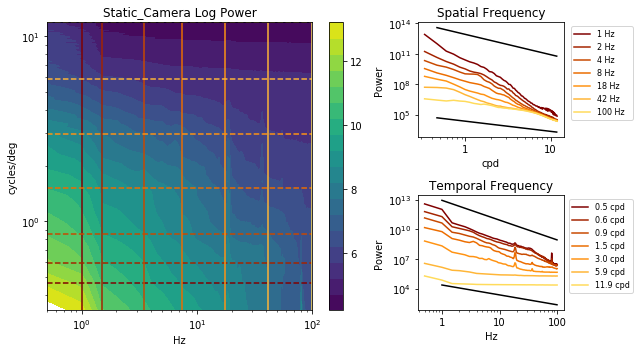

In [8]:
da_plot_power(static_ps_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  grey_contour=False, minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Static_Camera', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1, cmap='afmhot')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


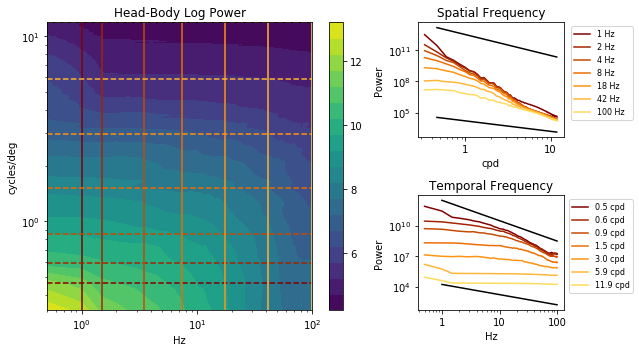

In [9]:
da_plot_power(headbody_ps_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  grey_contour=False, minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Head-Body', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1, cmap='afmhot')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


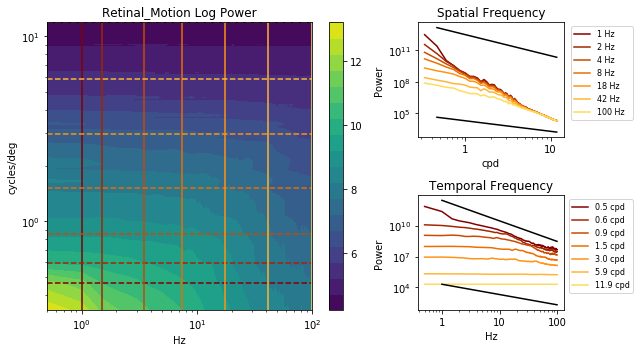

In [10]:
da_plot_power(eye_ps_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                   grey_contour=False, minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Retinal_Motion', 
                  saveloc=comparison_save_dir,vector_save=True,
                  legend_loc=1, cmap='afmhot')

## Plotter of Diff Power
Need to put this inside the plotter because we'll take the difference in log space so we can see directionality.;

In [11]:
def da_plot_diff_power(power_spectrum_a, power_spectrum_b, fqspace, fqtime, nsamples = 5, minmaxcolors=(None, None), figname='Plot', saveloc='./output', logscale=True, cmap= 'hsv', show_onef_line=True, grey_contour=True):
    '''
    THE Dong & Attick Plot (Dong & Attick 1995; fig 7) with heatmap added.
    Produces three plots:
        - Heatmap displying the joint spatial/temporal amplitude
        - Samples from this plot along spatial and temporal lines:
            * plots of spatial power spectrum along given temporal values
            * plots of temporal spectrum along given spatial values

    Parameters
    ----------
        power_spectrum:   2d numpy array of spatio/temporal power
        fqspace:    1d numpy array of spatial frequency vals for spectrum
        fqtime:   1d numpy array of temporal frequency vals for spectrum
        nsamples: integer number of lines to plot for sampling plots
        power (bool):   Are we calculating the power spectrum (default) or amplitude
        psd (bool):     Normalize to power spectral density (default), or raw power?
        figname (str):  String prefix to name of figure to be saved
    
    Returns:
    --------
        mftchunk
        azmchunk
        freqspace1d
        freqspacefull
        freqtime

    '''
    #dims got a little messed up. This is the quickest fix. Later go in and change idxs in code.
    #power_spectrum = power_spectrum.T
    
    #calculate sampling positions
    #space
    space_end_offset = 1
    space_end_sample = len(fqspace)-space_end_offset #sample everything for now
    #time
    time_end_offset = 1
    time_end_sample = len(fqtime)-time_end_offset #sample everything for now
    #joint
    n_datpoints = len(fqspace)*len(fqtime)
    
    #colors for lines: generate by indexes in log coordinates.
    spacesamplefqs_idx = np.round(np.geomspace(space_end_offset, space_end_sample,
                                      nsamples),0).astype(int)
    timesamplefqs_idx = np.round(np.geomspace(time_end_offset, time_end_sample,
                                     nsamples),0).astype(int)

    #spacecolors = np.array(['red', 'orange', 'green', 'blue', 'indigo'])#[::-1]
    spacecolors = lambda x: plt.cm.get_cmap(cmap)(x / nsamples * 0.5 + 0.25)
    timecolors = spacecolors

    #make a grid
    fig = plt.figure(figsize=(10,6))
    full_grid = gsp.GridSpec(2,3)
    
    #layout of subplots
    grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
    grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
    grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])
    
    #heatmap
    axes_hm = plt.subplot(grid_hm[0])
    
    #take log
    power_spectrum_d = np.log10(power_spectrum_a) - np.log10(power_spectrum_b)
    
    if(minmaxcolors[0] and minmaxcolors[1]):
        minc = minmaxcolors[0]
        maxc = minmaxcolors[1]
    else:
        minc = np.min(power_spectrum_d)
        maxc = np.max(power_spectrum_d)
        
    clev = np.arange(minc,maxc,0.5)
    if(grey_contour):
        hm = axes_hm.contourf(fqtime, fqspace, power_spectrum_d,
                              clev,
                              cmap='gray',
                              norm=mpl.colors.DivergingNorm(vmin=minc, vcenter=0, vmax=maxc))
    else:
        hm = axes_hm.contourf(fqtime, fqspace, power_spectrum_d,
                              clev,
                              cmap='PiYG_r',
                              norm=mpl.colors.DivergingNorm(vmin=minc, vcenter=0, vmax=maxc))
    if(logscale):
        axes_hm.set_xscale("log") 
        axes_hm.set_yscale("log")
    axes_hm.set_xlabel('Hz')
    axes_hm.set_ylabel('cycles/deg')
    axes_hm.set_title(f'{figname} Log Power') 
    plt.colorbar(hm)

    #add lines
    for s in range(nsamples):
        #lines in time
        axes_hm.axvline(fqtime[timesamplefqs_idx[s]],c=timecolors(s),ls='-')
        #lines in space
        axes_hm.axhline(fqspace[spacesamplefqs_idx[s]],c=spacecolors(s),ls='--')

    #spaceplot
    axes_space = plt.subplot(grid_space[0])
    for i, tf_idx in enumerate(timesamplefqs_idx):
        axes_space.semilogx(fqspace, power_spectrum_d[:,tf_idx],
                        label='{0:0.1f} Hz'.format(fqtime[tf_idx]),
                        c=timecolors(i))
    
    #print(np.log(np.max(power_spectrum)/fqspace))
    if(show_onef_line):
        fqs = fqspace[space_end_offset:space_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum_d[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum_d[:,timesamplefqs_idx[0]])
        axes_space.loglog(fqs, onef, c='black')
        axes_space.plot(fqs, onef2, c='black')
    
    axes_space.set_title('Spatial Frequency')
    axes_space.set_xlabel('cpd')
    axes_space.set_ylabel(f'Power')
    #axes_space.set_xlim(fqspace[1],fqspace[-1])
    #axes_space.set_ylim(bottom=minc) #, top=maxc)
    axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_space.legend(fontsize=8)

    #timeplot
    axes_time = plt.subplot(grid_time[0])
    for i, sf_idx in enumerate(spacesamplefqs_idx):
        axes_time.semilogx(fqtime, power_spectrum_d[sf_idx,:],
                       label='{0:0.1f} cpd'.format(fqspace[sf_idx]),
                       c=spacecolors(i))
        
    if(show_onef_line):
        fqs = fqtime[time_end_offset:time_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum_d[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum_d[:,timesamplefqs_idx[0]])
        axes_time.semilogx(fqs, onef, c='black')
        axes_time.plot(fqs, onef2, c='black')
        
    axes_time.set_title('Temporal Frequency')
    axes_time.set_xlabel('Hz')
    axes_time.set_ylabel(f'Power')
    #axes_time.set_xlim(fqtime[1],fqtime[-1])
    #axes_time.set_ylim(bottom=minc) #, top= maxc)
    axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_time.legend(fontsize=8)

    plt.tight_layout()
    
    plt.savefig(f'{saveloc}/Power_{figname}.png')

## Compare Static & Body/Head

In [12]:
minc = np.min((np.log10(headbody_ps_2d)-np.log10(static_ps_2d),
              np.log10(eye_ps_2d)-np.log10(static_ps_2d),
              np.log10(eye_ps_2d)-np.log10(headbody_ps_2d)))
maxc = np.max((np.log10(headbody_ps_2d)-np.log10(static_ps_2d),
              np.log10(eye_ps_2d)-np.log10(static_ps_2d),
              np.log10(eye_ps_2d)-np.log10(headbody_ps_2d)))

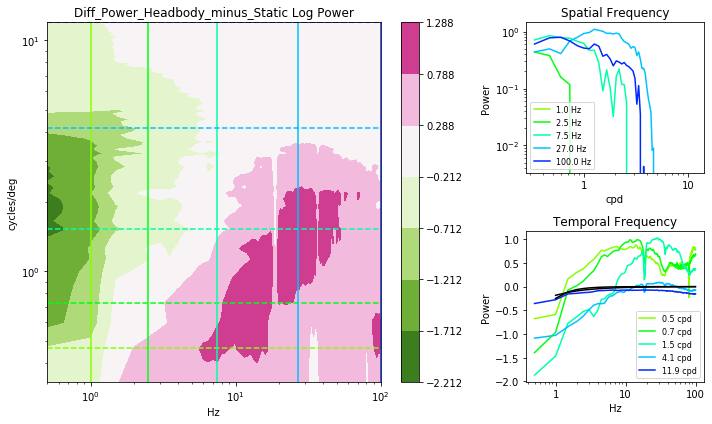

In [13]:
da_plot_diff_power(headbody_ps_2d, static_ps_2d, fqs_space, fqs_time, 
                   show_onef_line=True, logscale=True,
                  figname=f'Diff_Power_Headbody_minus_Static', 
                  saveloc=comparison_save_dir, grey_contour=False,
                  minmaxcolors=(minc, maxc))

## Compare Static & Eye

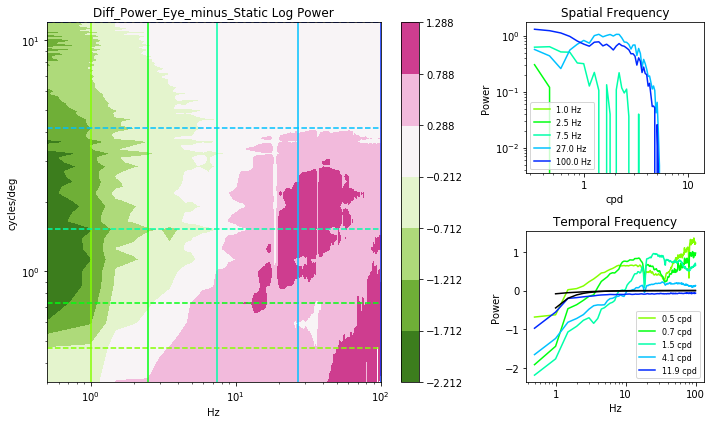

In [14]:
da_plot_diff_power(eye_ps_2d, static_ps_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Diff_Power_Eye_minus_Static', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Compare Body & Eye

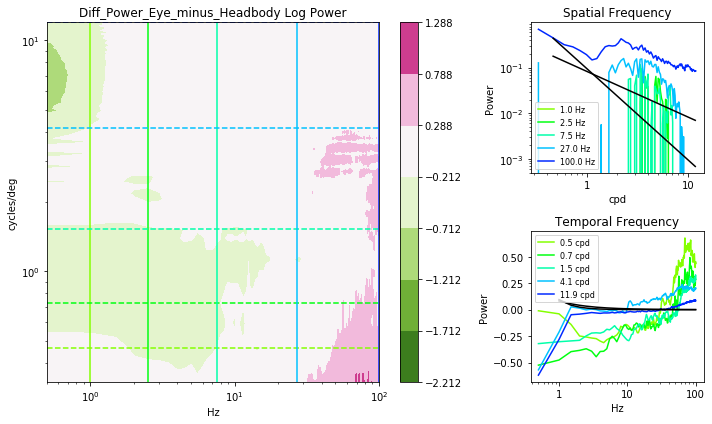

In [15]:
da_plot_diff_power(eye_ps_2d, headbody_ps_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Diff_Power_Eye_minus_Headbody', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Test Separability

We need to determine how close this function is to a separable function. According to  Constantinou et al 2015, (https://arxiv.org/pdf/1509.07017.pdf) We can do this by determining how factorizable the covariance matrix is.

Another reference is Simpson et al (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4203479/)

A more common method is looking at the rank of the matrix using SVD

The interesting relationship in the power spectrum (1/f law) is in log space. So take the log before running SVD. This also puts the values of the matrix to max 30 or so, which is more numerically stable for SVD (values before log are 10^15)

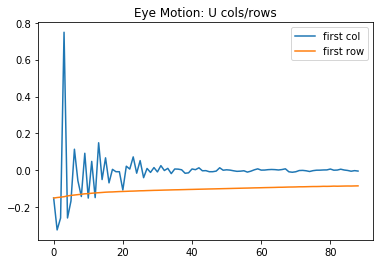

Sigma Values: [1692.3055862777858, 72.58742530911496, 17.66847324913983, 7.248006314027899, 3.939439301283203]


Text(0.5, 1.0, 'Static Camera: Sigma - first 30')

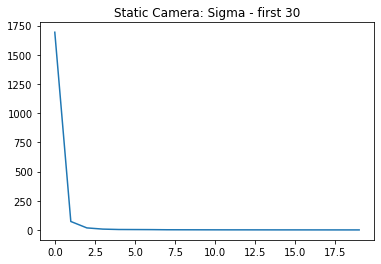

In [16]:
static_ps_2d_small = np.log(static_ps_2d)
u,s,v = np.linalg.svd(static_ps_2d_small)

plt.plot(u[0,:],label='first col')
plt.plot(u[:,0],label='first row')
plt.legend()
plt.title('Eye Motion: U cols/rows')
plt.show()

print(f'Sigma Values: {[l for l in s[:5]]}')
plt.plot(s[:20])
plt.title('Static Camera: Sigma - first 30')

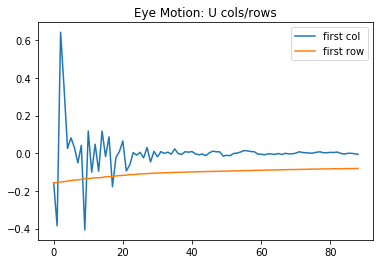

Sigma Values: [1717.8229365077618, 61.61626270140076, 12.477809431353267, 4.702908425161498, 3.7329903652555854]


Text(0.5, 1.0, 'Head Body: Sigma - first 30')

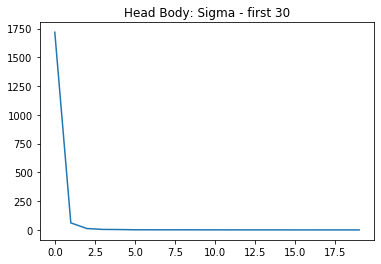

In [17]:
headbody_ps_2d_small = np.log(headbody_ps_2d)
u,s,v = np.linalg.svd(headbody_ps_2d_small)

plt.plot(u[0,:],label='first col')
plt.plot(u[:,0],label='first row')
plt.legend()
plt.title('Eye Motion: U cols/rows')
plt.show()

print(f'Sigma Values: {[l for l in s[:5]]}')
plt.plot(s[:20])
plt.title('Head Body: Sigma - first 30')

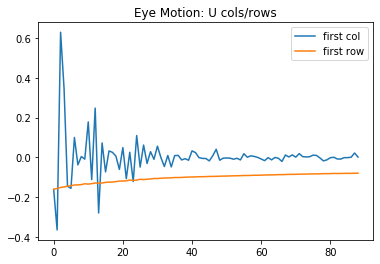

Sigma Values: [1744.5084653653348, 51.326636902937956, 12.890192951450167, 4.607959383594758, 2.860371756082079]


Text(0.5, 1.0, 'Sigma - first 30')

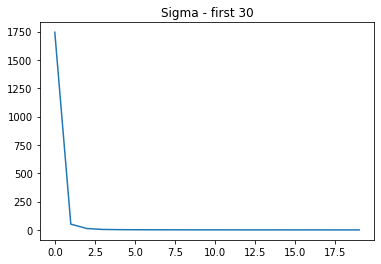

In [18]:
eye_ps_2d_small = np.log(eye_ps_2d)
u,s,v = np.linalg.svd(eye_ps_2d_small)

plt.plot(u[0,:],label='first col')
plt.plot(u[:,0],label='first row')
plt.legend()
plt.title('Eye Motion: U cols/rows')
plt.show()

print(f'Sigma Values: {[l for l in s[:5]]}')
plt.plot(s[:20])
plt.title('Sigma - first 30')

We seem to be in the realm of 'sort-of' separable. The first SV is large, and the second and beyond are much smaller. But they are definitely not zero either. Looking at the first column (spatial frequency), there is some noise. There is a trend towards more separable as more motion is included.